In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

DAY 3:

Success Indicators
You have now been asked to discover what key performance indicators (KPIs) will determine the success of the new design? Use at least completion rate, time spent on each step and error rates. Add any KPIs you might find relevant.

1) Completion Rate: The proportion of users who reach the final 'confirm' step.
2) Time Spent on Each Step: The average duration users spend on each step.
3) Error Rates: If there's a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

In [10]:
# Load your CSV or paste raw data
df = pd.read_csv("/Users/jon/Desktop/Ironhack/Unit 4 - Statistics & Probability/Project-Statistics/Databases/cleaned/df_cleaned_merged_web_data_pt.txt", parse_dates=["date_time"])

1) COMPLETION RATE

In [11]:
# Sort actions chronologically per visit
df = df.sort_values(by=["visit_id", "date_time"])

# Remove duplicate steps per visit (to avoid loops/skips being counted multiple times)
df_unique_steps = df.drop_duplicates(subset=["visit_id", "process_step"])

# Define the correct step order for the funnel
step_order = ["start", "step_1", "step_2", "step_3", "confirm"]

# Count how many unique visits reached each step
step_counts = df_unique_steps.groupby("process_step")["visit_id"].nunique().reindex(step_order, fill_value=0)

# Calculate funnel conversion from the first step
funnel = step_counts.to_frame(name="num_visits")
funnel["conversion_rate"] = funnel["num_visits"] / funnel["num_visits"].iloc[0] * 100  # % from start

# Calculate the conversion from Previous Step

funnel["step_conversion"] = funnel["num_visits"] / funnel["num_visits"].shift(1) * 100

# Display results
print("Funnel Conversion (% of users from 'start'):\n")
print(funnel)

Funnel Conversion (% of users from 'start'):

              num_visits  conversion_rate  step_conversion
process_step                                              
start             144902       100.000000              NaN
step_1            119255        82.300451        82.300451
step_2            104341        72.007978        87.494025
step_3             95093        65.625733        91.136754
confirm            89826        61.990863        94.461212


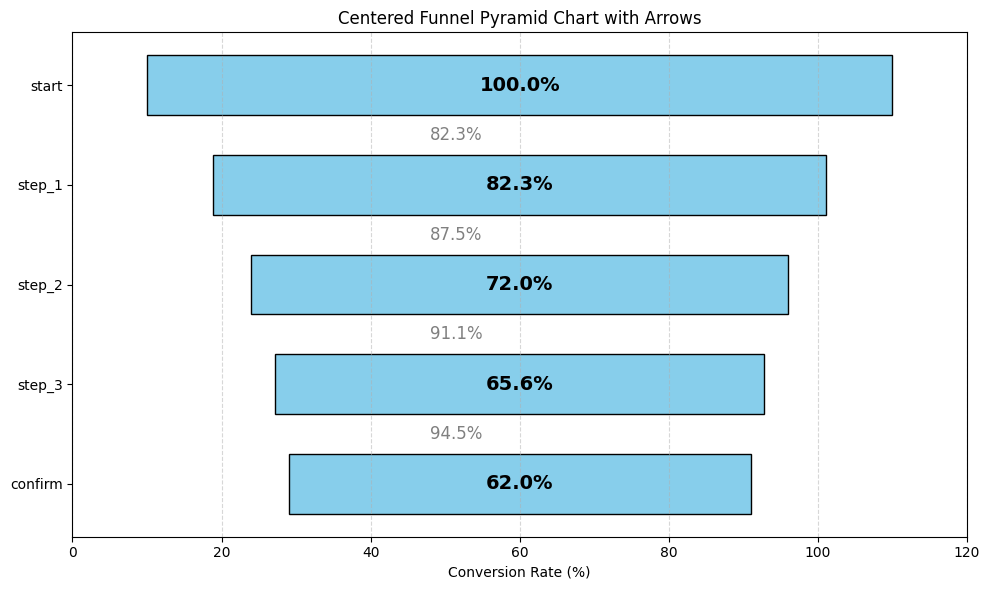

In [12]:
# Data
steps = funnel.index.tolist()
conversion_from_start = funnel["conversion_rate"].tolist()
conversion_from_previous = funnel["step_conversion"].tolist()

if np.isnan(conversion_from_previous[0]):
    conversion_from_previous[0] = 100.0

y = np.arange(len(steps))
x_center = 60
left_offsets = [x_center - (val / 2) for val in conversion_from_start]

plt.figure(figsize=(10, 6))

for i in range(len(steps)):
    plt.barh(y[i], conversion_from_start[i], height=0.6,
             left=left_offsets[i], color="skyblue", edgecolor="black")
    plt.text(x_center, y[i], f"{conversion_from_start[i]:.1f}%",
             va='center', ha='center', fontsize=14, fontweight='bold', color='black')

for i in range(1, len(steps)):
    y_mid = (y[i - 1] + y[i]) / 2
    label = f"{conversion_from_previous[i]:.1f}%"
    plt.text(x_center - 5, y_mid, label, ha="right", va="center", fontsize=12, color="gray")


plt.yticks(ticks=y, labels=steps)
plt.xlim(0, 120)
plt.gca().invert_yaxis()
plt.xlabel("Conversion Rate (%)")
plt.title("Centered Funnel Pyramid Chart with Arrows")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

2) TIME SPENT ON EACH STEP

In [13]:
# Shift next step timestamp within the same visit
df["next_time"] = df.groupby("visit_id")["date_time"].shift(-1)

# Calculate time spent at each step (in seconds)
df["time_spent"] = (df["next_time"] - df["date_time"]).dt.total_seconds()

# Drop last step per visit (no next_time available)
df_valid = df.dropna(subset=["time_spent"])

# Calculate average time spent per process_step
avg_time_per_step = df_valid.groupby("process_step")["time_spent"].mean().sort_values(ascending=False)

print("Average time per step (in seconds):")
print(avg_time_per_step)

Average time per step (in seconds):
process_step
confirm    256.857314
step_3     132.116471
step_2      92.450280
step_1      60.524441
start       58.696367
Name: time_spent, dtype: float64


3) ERROR RATE

In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'])

# Define the funnel steps
funnel_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
step_to_num = {step: i for i, step in enumerate(funnel_steps)}
df['step_num'] = df['process_step'].map(step_to_num)

# Sort by visit and time
df = df.sort_values(by=['visit_id', 'date_time'])

# Compute previous step per visit
df['prev_step_num'] = df.groupby('visit_id')['step_num'].shift(1)

# Flag regressions
df['regression'] = df['step_num'] < df['prev_step_num']

# Get sessions with at least one regression
regression_sessions = df[df['regression']].groupby('visit_id').first().reset_index()
regression_sessions = regression_sessions[['visit_id']]
regression_sessions['has_regression'] = True

# Merge with original to get client_id info
visits = df[['client_id', 'visit_id']].drop_duplicates()
visits = visits.merge(regression_sessions, on='visit_id', how='left')
visits['has_regression'] = visits['has_regression'].fillna(False)

# Compute regression rate per client
regression_rate = visits.groupby('client_id')['has_regression'].mean().reset_index()
regression_rate.rename(columns={'has_regression': 'regression_rate'}, inplace=True)

print(regression_rate)

# For each visit_id, it shouws the % of times the client_id regressed a step. 
# So if a client has 3 visits, and in 2 of them they regressed, the regression rate will be 66.7%.

        client_id  regression_rate
0             169         0.000000
1             336         0.000000
2             546         0.000000
3             555         0.000000
4             647         0.000000
...           ...              ...
120152    9999729         0.333333
120153    9999768         1.000000
120154    9999832         0.000000
120155    9999839         0.000000
120156    9999875         0.000000

[120157 rows x 2 columns]


/var/folders/_2/ksgd3nl52j9g0sxwpjjd1bgh0000gn/T/ipykernel_8039/2173506316.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  visits['has_regression'] = visits['has_regression'].fillna(False)


In [21]:
df['date_time'] = pd.to_datetime(df['date_time'])

# Define funnel steps and map to numbers
funnel_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
step_to_num = {step: i for i, step in enumerate(funnel_steps)}
df['step_num'] = df['process_step'].map(step_to_num)

# Sort by visit and timestamp
df = df.sort_values(by=['visit_id', 'date_time'])

# Compute previous step and label
df['prev_step_num'] = df.groupby('visit_id')['step_num'].shift(1)
df['prev_step_label'] = df.groupby('visit_id')['process_step'].shift(1)

# Flag regressions
df['regression'] = df['step_num'] < df['prev_step_num']

# Filter only regressions
regressions = df[df['regression']]

# Count regressions by previous step (i.e., where they regressed *from*)
regression_counts = regressions['prev_step_label'].value_counts().reset_index()
regression_counts.columns = ['from_step', 'regression_count']

# Add percentage column
total_regressions = regression_counts['regression_count'].sum()
regression_counts['percent of regressions'] = (regression_counts['regression_count'] / total_regressions * 100).round(2)

print(regression_counts)

  from_step  regression_count  percent of regressions
0    step_1             23630                   36.99
1    step_3             19355                   30.30
2    step_2             18126                   28.38
3   confirm              2767                    4.33


In [22]:
# Get total number of visits
total_visits = df['visit_id'].nunique()

# Get number of visits with at least one regression
visits_with_regressions = regressions['visit_id'].nunique()

# Compute error rate
error_rate = visits_with_regressions / total_visits * 100

# Print it nicely
print(f"\nTotal visits: {total_visits}")
print(f"Visits with regressions: {visits_with_regressions}")
print(f"⚠️ Error Rate: {error_rate:.2f}%")


Total visits: 158095
Visits with regressions: 40516
⚠️ Error Rate: 25.63%
